In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner. A surge in negative sentiment would indicate a crisis of some sort that would need to be addressed quickly, and thus negative sentiment was deemed to be the most important class for modeling purposes in the project. However, data on the level of positive sentiment is still very valuable information so a model that captures both sentiments as accurately as possible is most desirable.  

## Data Understanding:
The baseline data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions) dataset. From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th). The data contained ternary (positive, neutral, negative) sentiment data which was filtered down to binary (positive, negative) classes for modeling purposes. 

During the modeling process, the class imbalance in the data was shown to interfer with model performance, and additional negative sentiment data was used to augment the baseline data. 1,117 rows of negative general topic tweets were obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets), and an additional 1,219 negative apple tweets were procured from [data.world](https://data.world/crowdflower/apple-twitter-sentiment). This data augmentation greatly improved model performance.

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as vz
from src import functions as fn
from src import classes as cl 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline 

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Modeling I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = path = os.path.join(gparent, 'data/processed',\
                           'baseline_data.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone hr tweeting rise austin dead need up...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        8908 non-null   int64 
 1   stems          8908 non-null   object
 2   lemmas         8908 non-null   object
 3   tweet          8908 non-null   object
 4   brand_product  3271 non-null   object
 5   hashtags       8899 non-null   object
dtypes: int64(1), object(5)
memory usage: 417.7+ KB


## EDA & Corpus Statistics 

In [6]:
df.emotion.value_counts(normalize=True)

2    0.602941
0    0.333184
1    0.063875
Name: emotion, dtype: float64

## Splitting Emotions

In [7]:
positive = df[df['emotion']==0]
negative = df[df['emotion']==1]
neutral = df[df['emotion']==2]

## Emotion Vocabularies

#### Positive Lemma Vocabulary

In [8]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4516

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [9]:
pos_words = fn.words(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

ipad      		0.0441    
apple     		0.0333    
google    		0.0262    
store     		0.02      
iphone    		0.0197    
app       		0.0142    
new       		0.0129    
austin    		0.0105    
pop       		0.0076    
android   		0.0074    
get       		0.0065    
launch    		0.0062    
party     		0.0054    
one       		0.0054    
line      		0.0052    
great     		0.0049    
time      		0.0049    
via       		0.0047    
day       		0.0045    
free      		0.0044    
social    		0.0044    
circle    		0.0044    
win       		0.0044    
cool      		0.0043    
map       		0.0042    


<font size="4">Fill</font> 

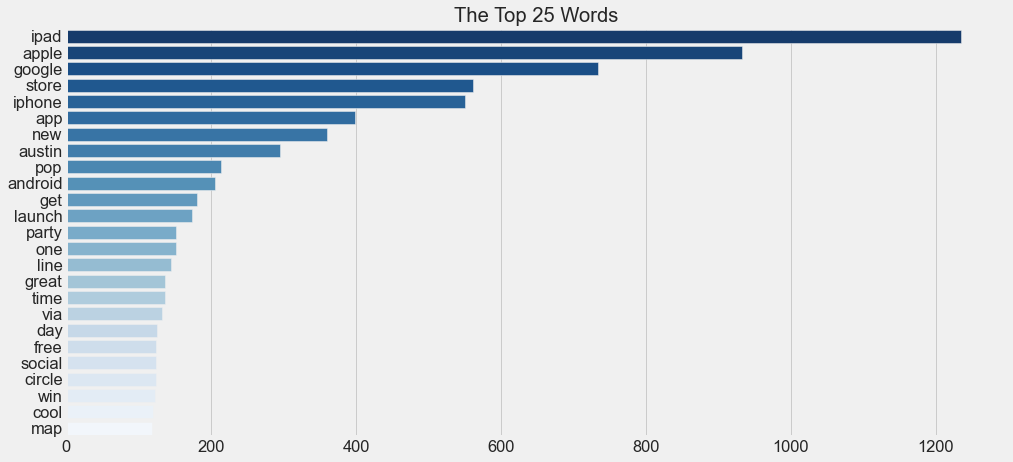

In [10]:
vz.top_word_list(pos_words, 25)

<font size="4">Fill</font>

#### Negative Lemmas Vocabulary

In [11]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

1883

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [12]:
neg_words = fn.words(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

ipad      		0.0373    
iphone    		0.0294    
google    		0.0271    
apple     		0.022     
app       		0.0108    
store     		0.0084    
new       		0.0077    
like      		0.0077    
circle    		0.0066    
need      		0.0063    
social    		0.0056    
apps      		0.0054    
design    		0.0052    
people    		0.0052    
austin    		0.005     
get       		0.0045    
android   		0.0043    
one       		0.0041    
think     		0.0041    
time      		0.0041    
line      		0.0039    
launch    		0.0039    
day       		0.0039    
today     		0.0038    
look      		0.0038    


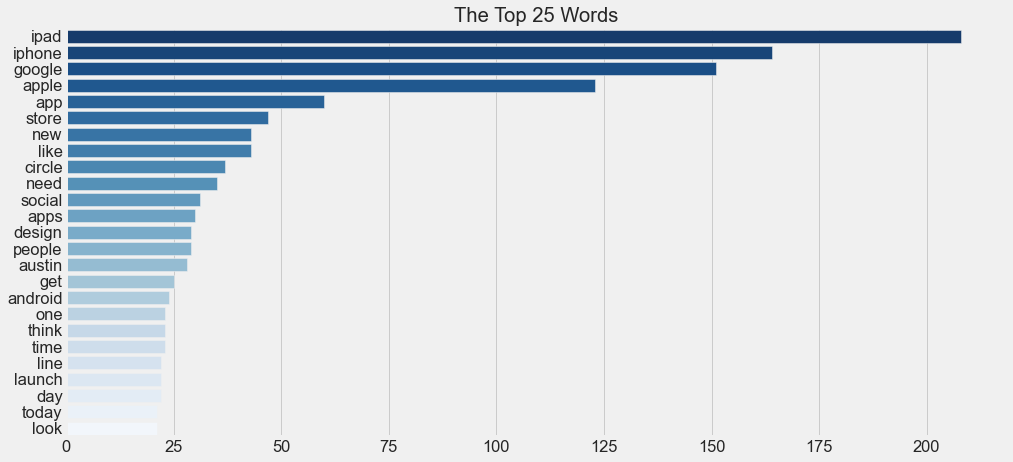

In [13]:
vz.top_word_list(neg_words, 25)

<font size="4">FILL.</font> 

#### Neutral Lemmas Vocabulary

In [14]:
vocab_lem_neu = fn.vocabulary(neutral.lemmas)
len(vocab_lem_pos)

4516

In [15]:
neu_words = fn.words(neutral.lemmas)
fn.word_frequencies(neu_words, 25)

Word 			Frequency

google    		0.0353    
ipad      		0.0309    
apple     		0.0257    
store     		0.0185    
iphone    		0.0174    
new       		0.0139    
austin    		0.0131    
circle    		0.0104    
social    		0.0102    
launch    		0.0099    
today     		0.0089    
app       		0.0074    
android   		0.0074    
pop       		0.0074    
network   		0.0073    
via       		0.0058    
line      		0.0056    
called    		0.0056    
free      		0.0054    
get       		0.0051    
party     		0.0049    
mobile    		0.0049    
major     		0.0046    
possibly  		0.0038    
check     		0.0036    


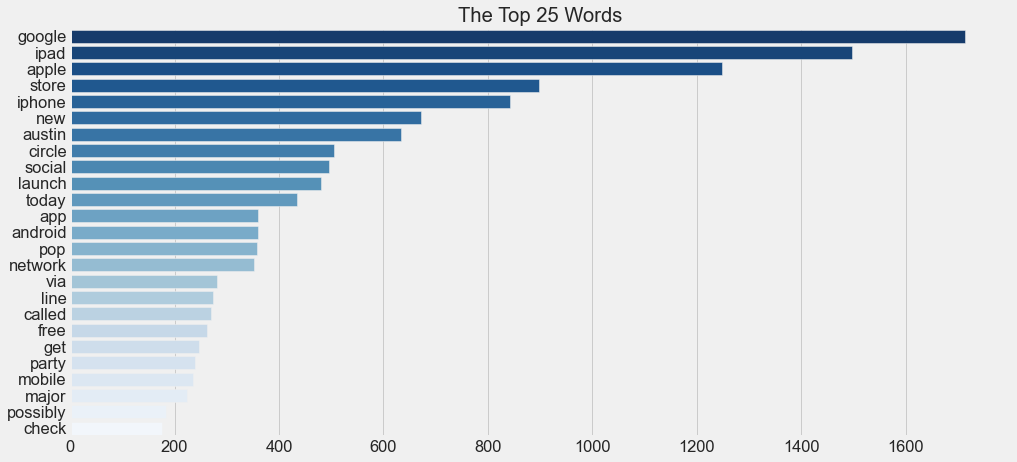

In [16]:
vz.top_word_list(neu_words, 25)

## Word Clouds

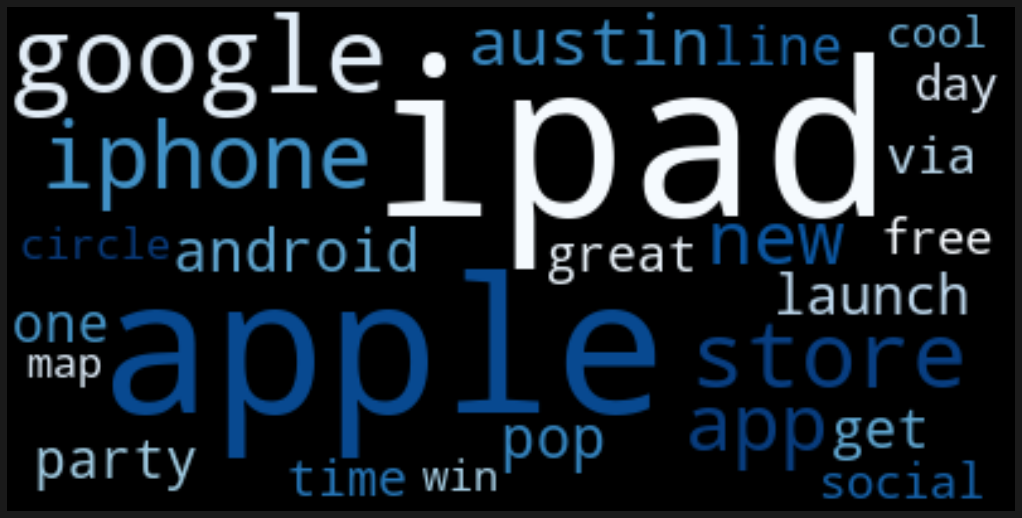

In [17]:
vz.word_cloud(pos_words, 25)

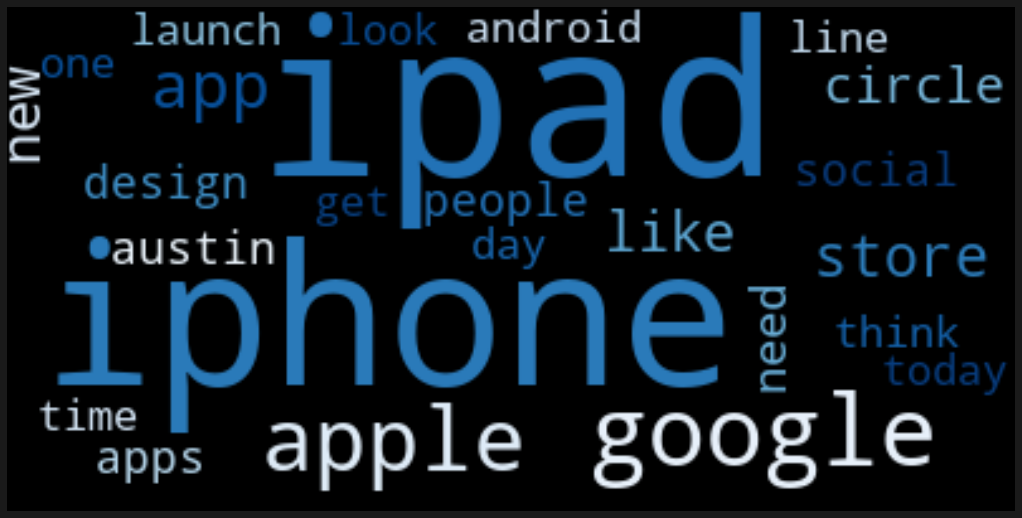

In [18]:
vz.word_cloud(neg_words, 25)

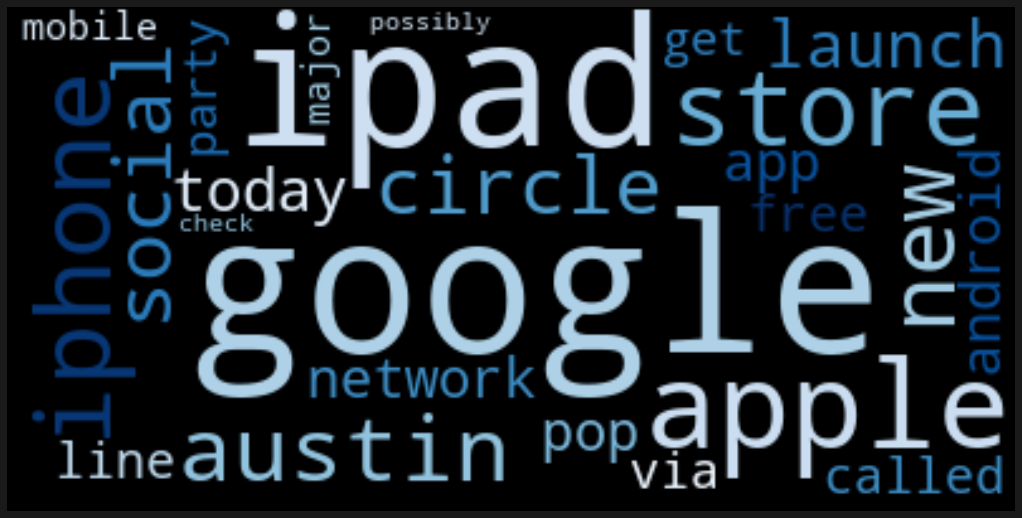

In [19]:
vz.word_cloud(neu_words, 25)

## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [20]:
# filtering
binary_data = df[(df['emotion'] == 0) |\
                 (df['emotion'] == 1)].copy()

In [21]:
# resetting the index
binary_data.reset_index(drop=True, inplace=True)

In [22]:
# checking the first five rows
binary_data.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone hr tweeting rise austin dead need up...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


In [23]:
# checking the info
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


In [24]:
# checking for nulls
binary_data.isna().sum()

emotion            0
stems              0
lemmas             0
tweet              0
brand_product    357
hashtags           6
dtype: int64

In [25]:
# checking the value counts
binary_data['emotion'].value_counts()

0    2968
1     569
Name: emotion, dtype: int64

In [26]:
binary_data['emotion'].value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [27]:
data_lemms = binary_data.lemmas
data_stems = binary_data.stems
target = binary_data['emotion']

In [28]:
data_lemms.isna().sum()
data_stems.isna().sum()

0

In [29]:
target.isna().sum()

0

In [30]:
# checking lengths
idx = [data_lemms, data_stems, target]
for i in idx:
    print(f'{len(i)}')

3537
3537
3537


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

In [31]:
# Creating data & target
X_lem = data_lemms
y_lem = target

In [32]:
# checking lengths
print(len(X_lem))
print(len(y_lem))

3537
3537


<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [33]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem,
                                                                           y_lem)

In [34]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

2652
2652
885
885


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [35]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training,
                                                             y_lem_training)

In [36]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

1989
1989
663
663


#### Stemmed Data

In [37]:
X_stem = data_stems
y_stem = target

In [38]:
# checking lengths
print(len(X_stem))
print(len(y_stem))

3537
3537


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [39]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem,
                                                                               y_stem)

In [40]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

2652
2652
885
885


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [41]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training,
                                                                 y_stem_training)

In [42]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

1989
1989
663
663


In [43]:
len(X_stem) == len(y_stem)

True

## Modeling Objects

In [44]:
# creating f1 scorer
f1 = fn.f1

# creating Harness
modeling = cl.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer()

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Creating a Basline Classifier

In [45]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [46]:
steps = [('tfidf', tfidf), ('clf', LR)]
baseline = Pipeline(steps=steps)

In [47]:
baseline.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [48]:
modeling.report(baseline, X_lem_train, y_lem_train, 'LR baseline',
                'tfidf/no ngrams, no sampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR baseline has an average F1 of 0.07139461065712163


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


array([0.03076923, 0.08955224, 0.11764706, 0.03076923, 0.08823529])

In [49]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"


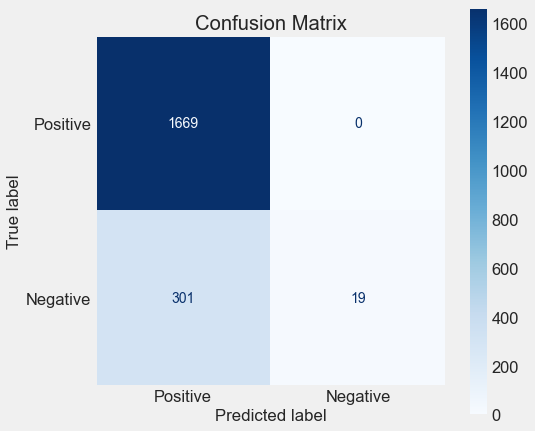

,F1,Recall,Precision
0,0.112094,0.059375,1.0


In [50]:
fn.confusion_report(baseline, X_lem_train, y_lem_train)

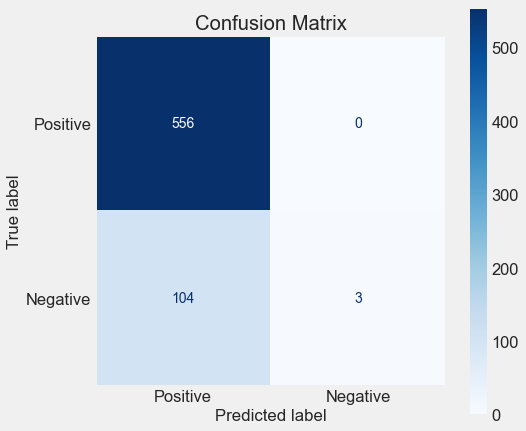

,F1,Recall,Precision
0,0.054545,0.028037,1.0


In [51]:
fn.confusion_report(baseline, X_lem_val, y_lem_val)

## Baseline Model Metrics:
<font size="4">F1=0.054545, Recall=0.028037, Precision=1.0</font>

## Baseline Coefficients & Odds

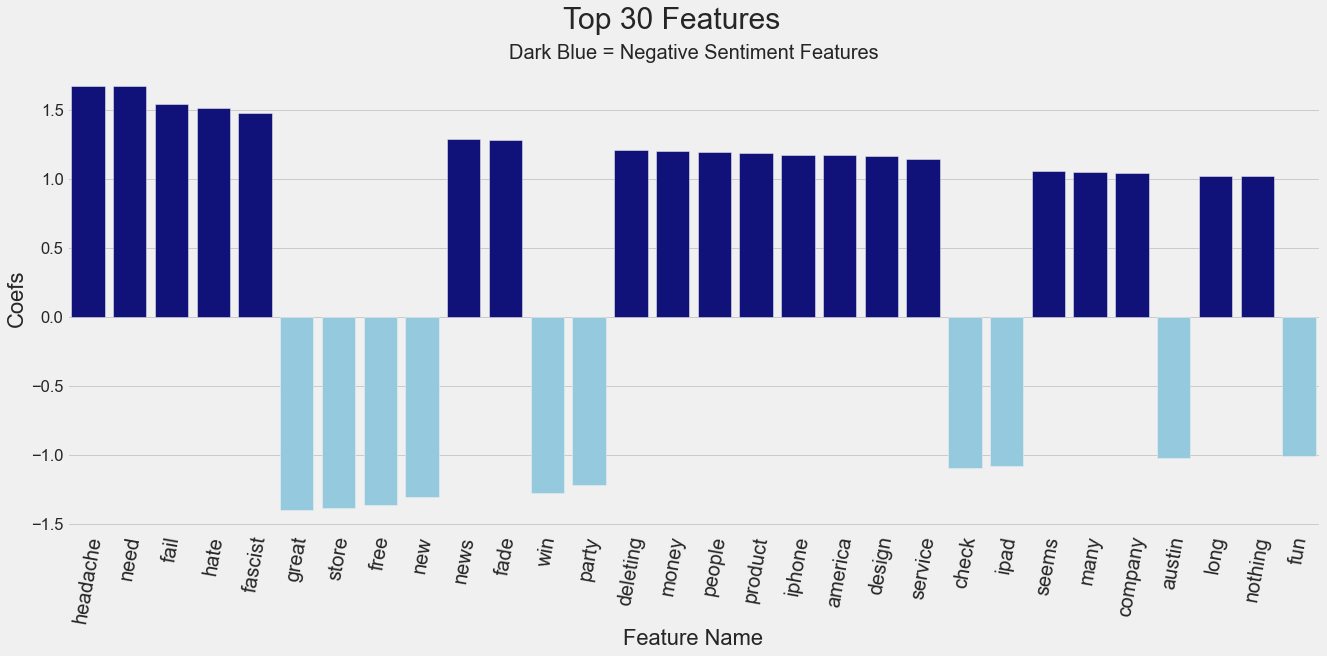

In [52]:
vz.base_coefs(baseline)

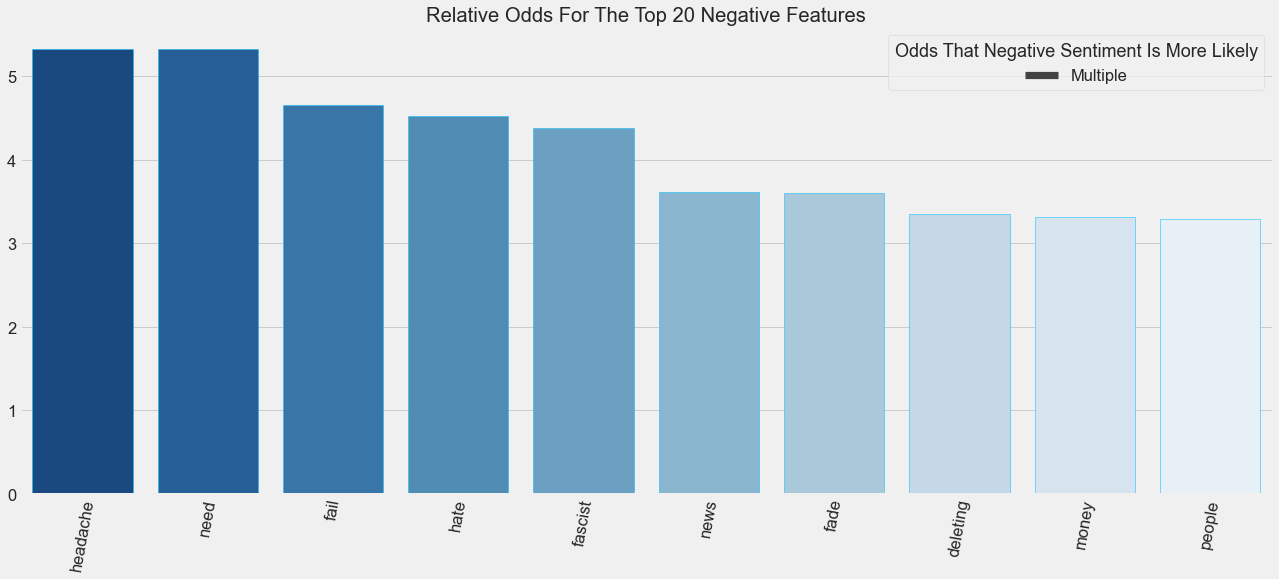

In [53]:
vz.base_neg_odds(baseline)

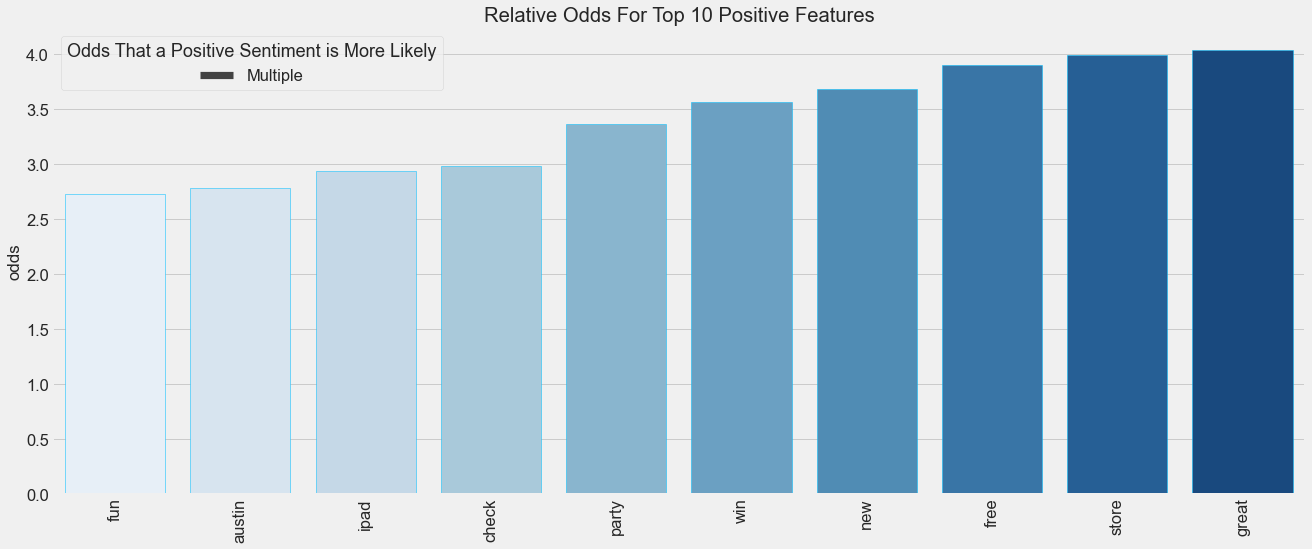

In [54]:
vz.base_pos_odds(baseline)

## Fitting Baseline Model on All Lemmatized Baseline Data

In [55]:
baseline.fit(X_lem, y_lem)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Pickling Baseline Model

In [56]:
# path = os.path.join(gparent, 'models', 'baseline_model.pkl')
# file = open(path, 'wb')
# pickle.dump(baseline, file)
# file.close()

## Baseline Minority Oversampling

In [57]:
target.value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

In [58]:
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', LR)]
baseline_mo = Pipeline(steps=steps)

In [59]:
baseline_mo.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [60]:
modeling.report(baseline_mo, X_lem_train, y_lem_train, 'baseline_mo',
                'minority oversampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


baseline_mo has an average F1 of 0.48333863118994547


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.47457627, 0.528     , 0.46511628, 0.45669291, 0.49230769])

In [61]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,baseline_mo,0.483339,minority oversampling


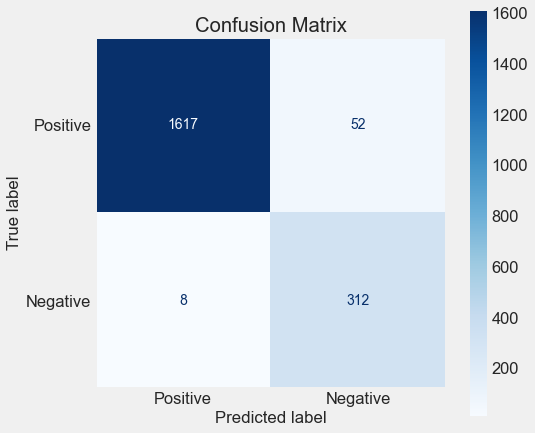

,F1,Recall,Precision
0,0.912281,0.975,0.857143


In [62]:
fn.confusion_report(baseline_mo, X_lem_train, y_lem_train)

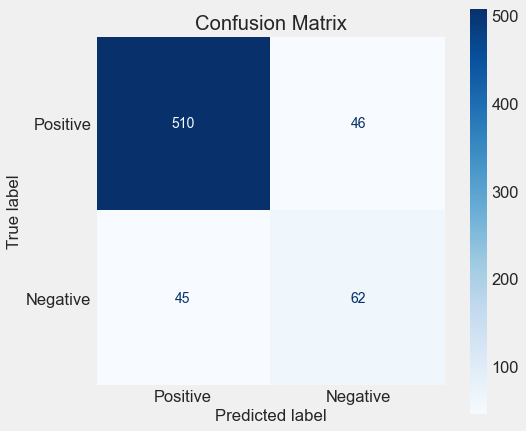

,F1,Recall,Precision
0,0.576744,0.579439,0.574074


In [63]:
fn.confusion_report(baseline_mo, X_lem_val, y_lem_val)

## Baseline Minority Oversampling GridSearch

In [64]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [65]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [66]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [67]:
# grid_clf_f1 = GridSearchCV(baseline_mo, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [68]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [69]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  LogisticRegression(C=1.2742749857031321, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [70]:
tuned_baseline_mo = Pipeline(steps=saved_steps)
tuned_baseline_mo.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(C=1.2742749857031321, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [71]:
modeling.report(tuned_baseline_mo, X_lem_train, y_lem_train, 'tuned_baseline_mo',
                f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_mo has an average F1 of 0.4787646911825066


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.45217391, 0.55      , 0.43902439, 0.46031746, 0.49230769])

In [72]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
2,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
1,baseline_mo,0.483339,minority oversampling


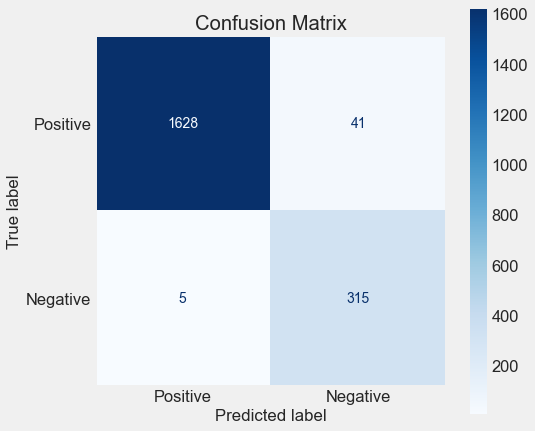

,F1,Recall,Precision
0,0.931953,0.984375,0.884831


In [73]:
fn.confusion_report(tuned_baseline_mo, X_lem_train, y_lem_train)

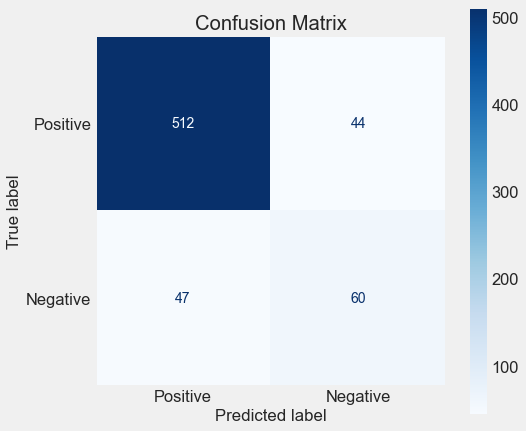

,F1,Recall,Precision
0,0.56872,0.560748,0.576923


In [74]:
fn.confusion_report(tuned_baseline_mo, X_lem_val, y_lem_val)

## Baseline SMOTE 

In [75]:
steps = [('tfidf', tfidf), ('oversample', sm), ('clf', LR)]
baseline_smote = Pipeline(steps=steps)

In [76]:
baseline_smote.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [77]:
modeling.report(baseline_smote, X_lem_train, y_lem_train, 'baseline smote',
                'smote')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


baseline smote has an average F1 of 0.4500063830905937


array([0.44642857, 0.528     , 0.41538462, 0.40909091, 0.45112782])

In [78]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
3,baseline smote,0.450006,smote
1,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,baseline_mo,0.483339,minority oversampling


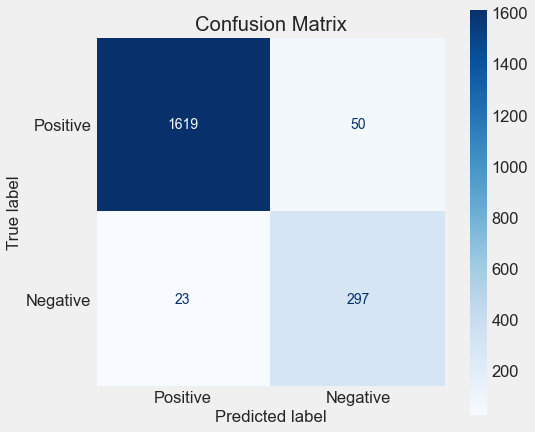

,F1,Recall,Precision
0,0.890555,0.928125,0.855908


In [79]:
fn.confusion_report(baseline_smote, X_lem_train, y_lem_train)

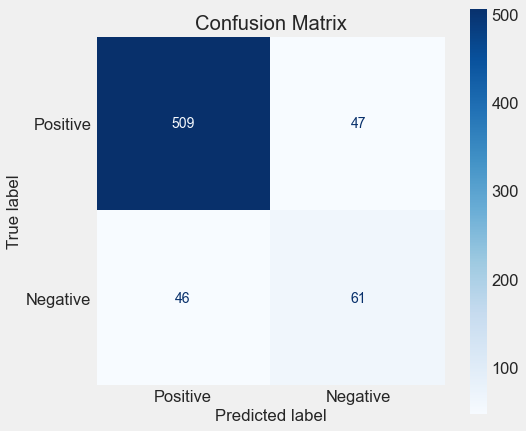

,F1,Recall,Precision
0,0.567442,0.570093,0.564815


In [80]:
fn.confusion_report(baseline_smote, X_lem_val, y_lem_val)

## Baseline SMOTE GridSearch

In [81]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }


In [82]:
# grid_clf = GridSearchCV(baseline_smote, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [83]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [84]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample', SMOTE(random_state=2021)),
 ('clf',
  LogisticRegression(C=5.455594781168514, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [85]:
tuned_baseline_smote = Pipeline(steps=saved_steps)
tuned_baseline_smote.fit( X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(C=5.455594781168514, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [86]:
modeling.report(tuned_baseline_smote, X_lem_train, y_lem_train,
                'tuned_baseline_smote', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear]tuned_baseline_smote has an average F1 of 0.4611620114772445


array([0.44036697, 0.5       , 0.43103448, 0.46774194, 0.46666667])

In [87]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,baseline smote,0.450006,smote
4,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline_mo,0.483339,minority oversampling


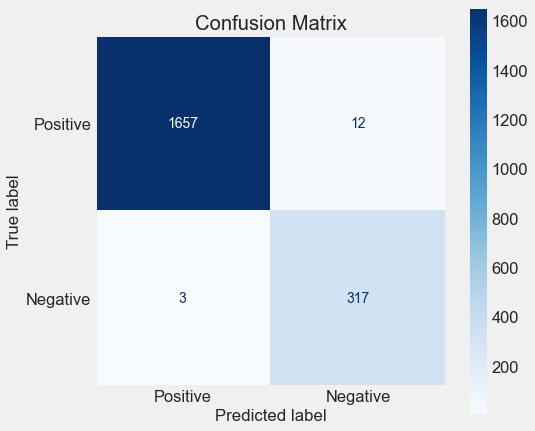

,F1,Recall,Precision
0,0.976888,0.990625,0.963526


In [88]:
fn.confusion_report(tuned_baseline_smote, X_lem_train, y_lem_train)

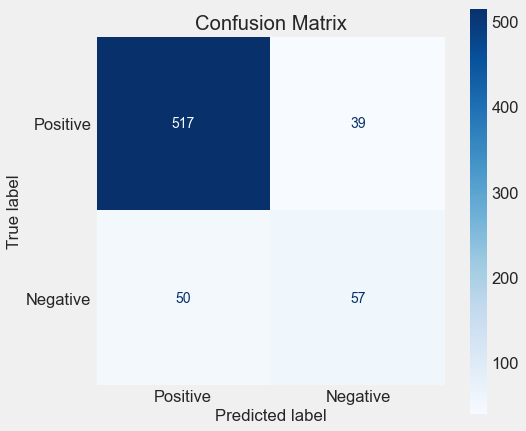

,F1,Recall,Precision
0,0.561576,0.53271,0.59375


In [89]:
fn.confusion_report(tuned_baseline_smote, X_lem_val, y_lem_val)

## Naive Bayes

In [90]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB())])

In [91]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes', 'minority oversamp')

multibayes has an average F1 of 0.4854208738826665


array([0.47222222, 0.47482014, 0.47058824, 0.50314465, 0.50632911])

In [92]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,baseline smote,0.450006,smote
2,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,baseline_mo,0.483339,minority oversampling
5,multibayes,0.485421,minority oversamp


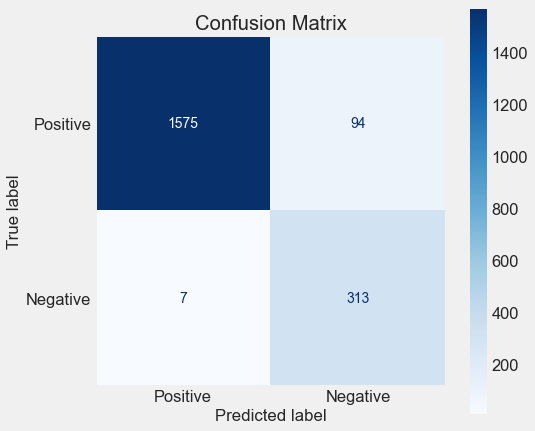

,F1,Recall,Precision
0,0.861073,0.978125,0.769042


In [93]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

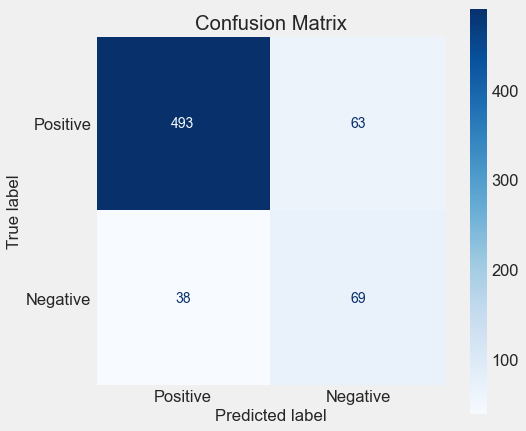

,F1,Recall,Precision
0,0.577406,0.64486,0.522727


In [94]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Naive Bayes

In [95]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [96]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, 25, .5, .75, 1],
    'clf__class_prior': [None, [.16, .84]],
    'clf__fit_prior': [True, False]
    }


In [97]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [98]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [99]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf', MultinomialNB(alpha=0.5))]

In [100]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB(alpha=0.5))])

In [101]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_multibayes',
                f'{steps}')

tuned_multibayes has an average F1 of 0.4840121240172661


array([0.50359712, 0.45669291, 0.45945946, 0.47682119, 0.52348993])

In [102]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,baseline smote,0.450006,smote
2,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,baseline_mo,0.483339,minority oversampling
6,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,multibayes,0.485421,minority oversamp


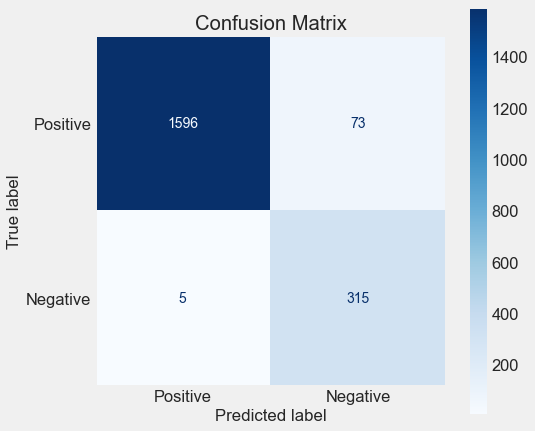

,F1,Recall,Precision
0,0.889831,0.984375,0.811856


In [103]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

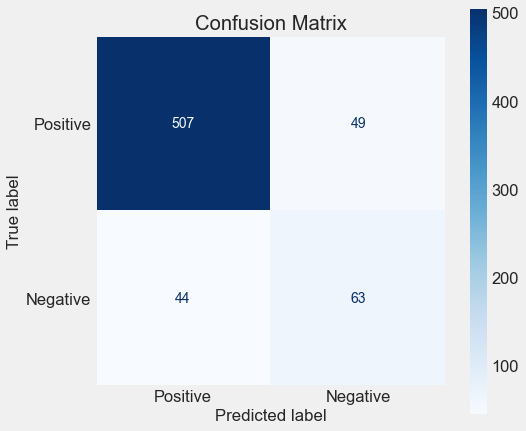

,F1,Recall,Precision
0,0.575342,0.588785,0.5625


In [104]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest

In [105]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', RF)]
rf_pipe = Pipeline(steps=steps)
rf_pipe.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [106]:
modeling.report(rf_pipe, X_lem_train, y_lem_train, 'rf_mo',
                'default random forest')

rf_mo has an average F1 of 0.3945792415948822


array([0.38095238, 0.36781609, 0.44210526, 0.4       , 0.38202247])

In [107]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
7,rf_mo,0.394579,default random forest
1,baseline smote,0.450006,smote
2,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,baseline_mo,0.483339,minority oversampling
5,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,multibayes,0.485421,minority oversamp


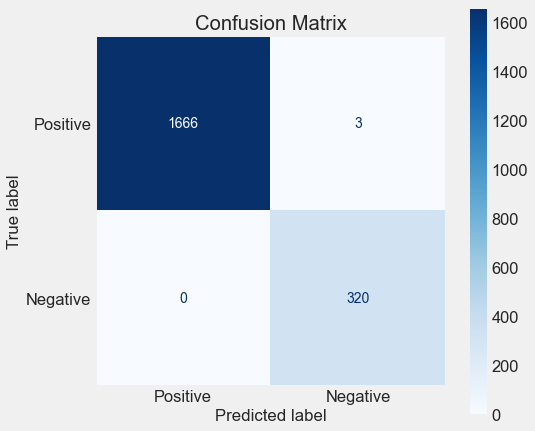

,F1,Recall,Precision
0,0.995334,1.0,0.990712


In [108]:
fn.confusion_report(rf_pipe, X_lem_train, y_lem_train)

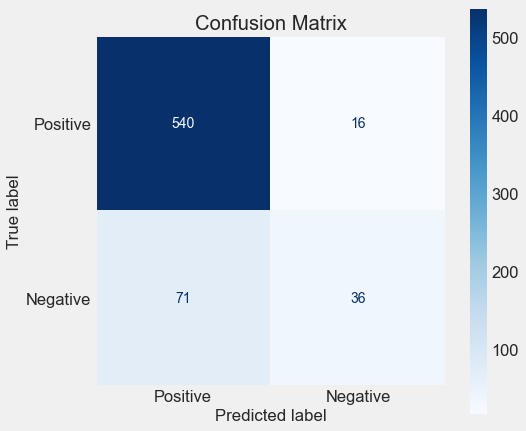

,F1,Recall,Precision
0,0.45283,0.336449,0.692308


In [109]:
fn.confusion_report(rf_pipe, X_lem_val, y_lem_val)

## Tuned Random Forest

In [110]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [111]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [112]:
# grid_clf = GridSearchCV(rf_pipe, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [113]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [114]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  RandomForestClassifier(max_features=None, min_samples_split=10, n_estimators=50,
                         n_jobs=-1, random_state=2021))]

In [115]:
tuned_rf = Pipeline(steps=saved_steps)
tuned_rf.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 RandomForestClassifier(max_features=None, min_samples_split=10,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=2021))])

In [116]:
modeling.report(tuned_rf, X_lem_train, y_lem_train, 'tuned_rf', f'{steps}')

tuned_rf has an average F1 of 0.46890918980355834


array([0.5203252 , 0.42975207, 0.47887324, 0.41935484, 0.4962406 ])

In [117]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,baseline_mo,0.483339,minority oversampling
6,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
7,multibayes,0.485421,minority oversamp


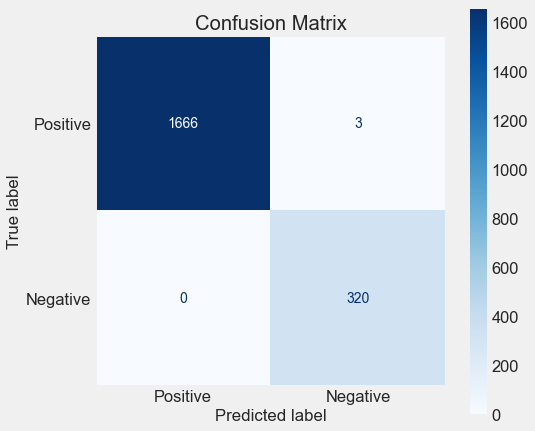

,F1,Recall,Precision
0,0.995334,1.0,0.990712


In [118]:
fn.confusion_report(tuned_rf, X_lem_train, y_lem_train)

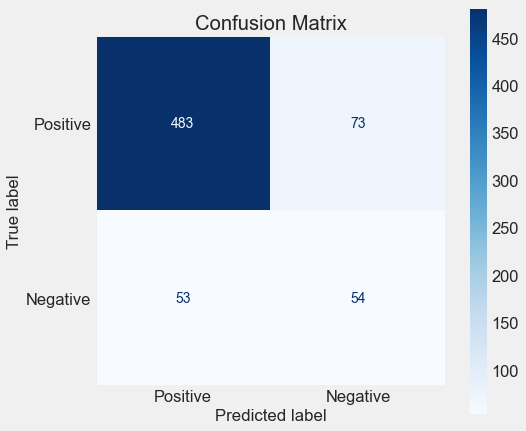

,F1,Recall,Precision
0,0.461538,0.504673,0.425197


In [119]:
fn.confusion_report(tuned_rf, X_lem_val, y_lem_val)

## Importing Augmented Data

In [120]:
path = os.path.join(gparent, 'data/processed', 'augmented_data.csv')
aug = pd.read_csv(path, encoding='unicode_escape')

## EDA & Augmented Corpus Statistics 

In [121]:
aug.emotion.value_counts(normalize=True)

2    0.477762
0    0.264010
1    0.258228
Name: emotion, dtype: float64

## Splitting Emotions

In [122]:
positive = aug[aug['emotion']==0]
negative = aug[aug['emotion']==1]
neutral = aug[aug['emotion']==2]

## Augmented Emotion Vocabularies

#### Positive Lemma Vocabulary

In [123]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4631

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [124]:
pos_words = fn.cloud_cleaner_lem(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

ipad      		0.0441    
apple     		0.0333    
google    		0.0262    
store     		0.02      
iphone    		0.0197    
app       		0.0143    
new       		0.0129    
austin    		0.0105    
pop       		0.0076    
android   		0.0074    
get       		0.0065    
launch    		0.0062    
party     		0.0054    
one       		0.0054    
line      		0.0052    
great     		0.0049    
time      		0.0049    
via       		0.0047    
day       		0.0045    
free      		0.0044    
social    		0.0044    
circle    		0.0044    
win       		0.0044    
cool      		0.0043    
map       		0.0043    


<font size="4">Fill</font> 

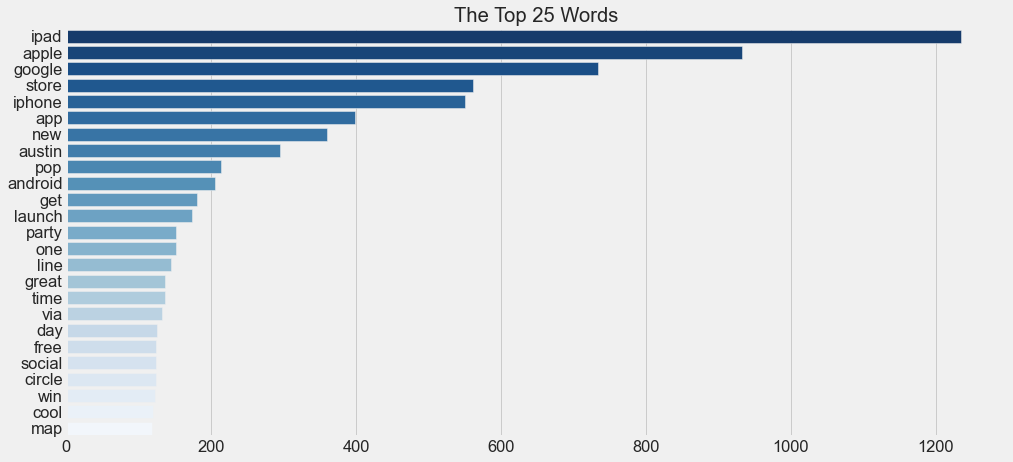

In [125]:
vz.top_word_list(pos_words, 25)

<font size="4">Fill</font>

#### Negative Lemmas Vocabulary

In [126]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

4947

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [127]:
neg_words = fn.cloud_cleaner_lem(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

unhappy   		0.0369    
iphone    		0.0145    
apple     		0.0141    
ipad      		0.011     
need      		0.0083    
google    		0.0074    
one       		0.0074    
phone     		0.0073    
get       		0.0069    
like      		0.0067    
aapl      		0.0062    
battery   		0.0058    
want      		0.0055    
u         		0.0055    
f0ck      		0.0054    
people    		0.0051    
make      		0.0048    
new       		0.0046    
computer  		0.0046    
time      		0.0044    
sh1t      		0.0044    
store     		0.0043    
please    		0.0041    
app       		0.004     
future    		0.0037    


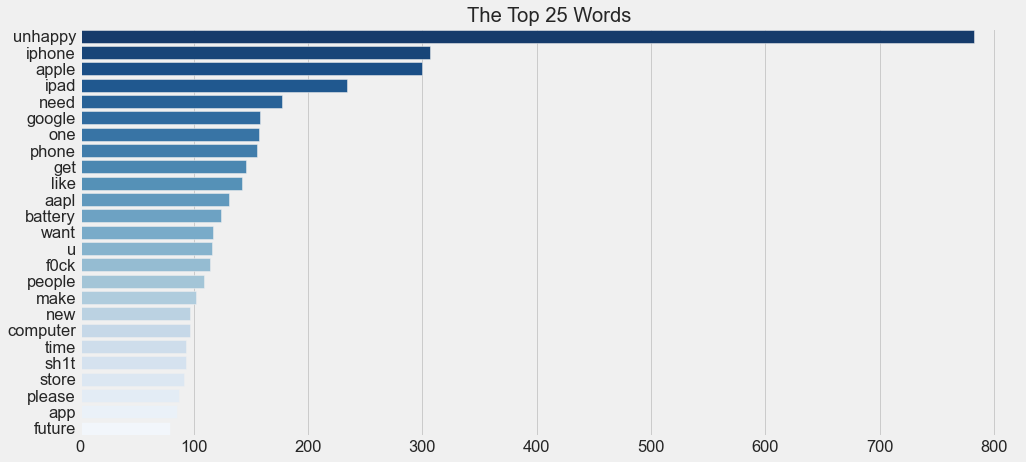

In [128]:
vz.top_word_list(neg_words, 25)

<font size="4">FILL.</font> 

#### Neutral Lemmas Vocabulary

In [129]:
vocab_lem_neu = fn.vocabulary(neutral.lemmas)
len(vocab_lem_pos)

4631

In [130]:
neu_words = fn.cloud_cleaner_lem(neutral.lemmas)
fn.word_frequencies(neu_words, 25)

Word 			Frequency

google    		0.0354    
ipad      		0.0309    
apple     		0.0258    
store     		0.0185    
iphone    		0.0174    
new       		0.0139    
austin    		0.0131    
circle    		0.0104    
social    		0.0102    
launch    		0.0099    
today     		0.009     
app       		0.0074    
android   		0.0074    
pop       		0.0074    
network   		0.0073    
via       		0.0058    
line      		0.0057    
called    		0.0056    
free      		0.0054    
get       		0.0051    
party     		0.0049    
mobile    		0.0049    
major     		0.0046    
possibly  		0.0038    
u         		0.0037    


## Word Clouds

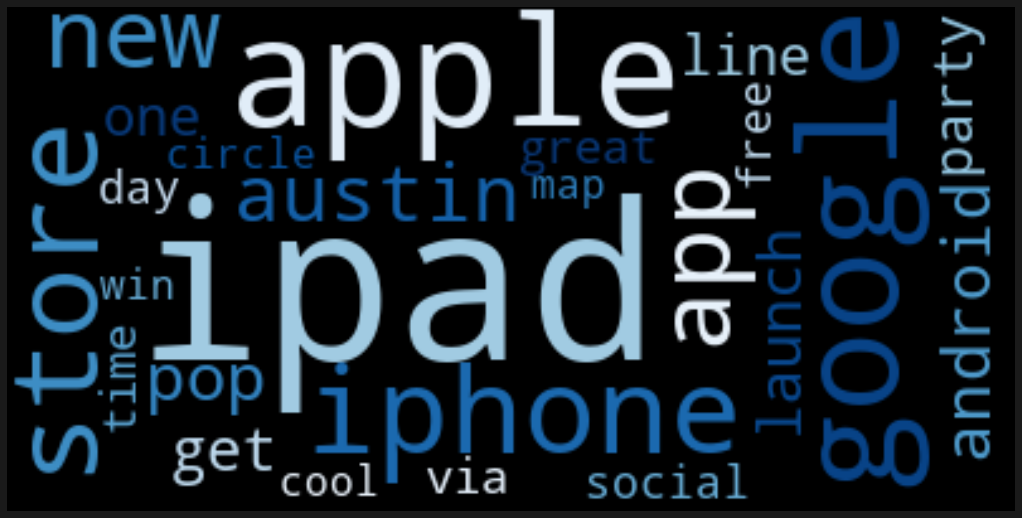

In [131]:
vz.word_cloud(pos_words, 25)

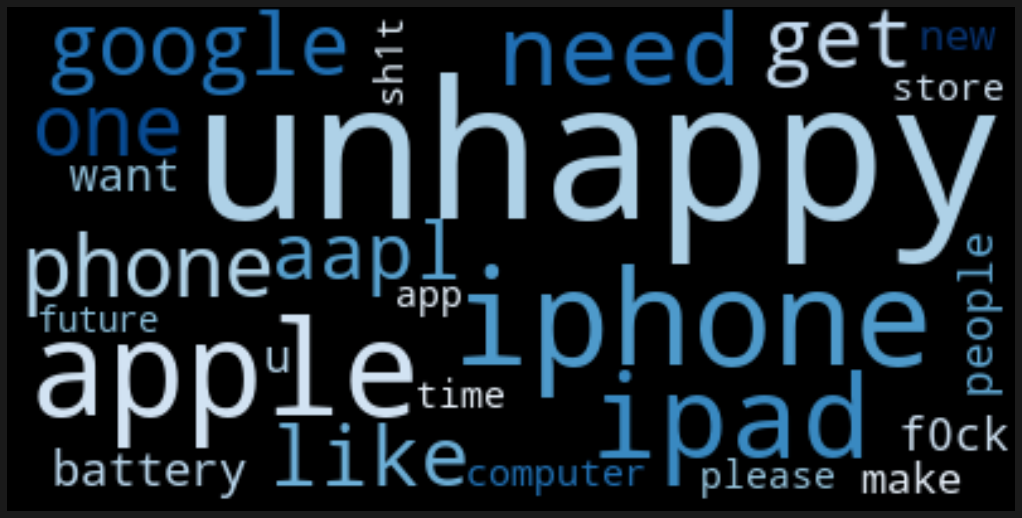

In [132]:
vz.word_cloud(neg_words, 25)

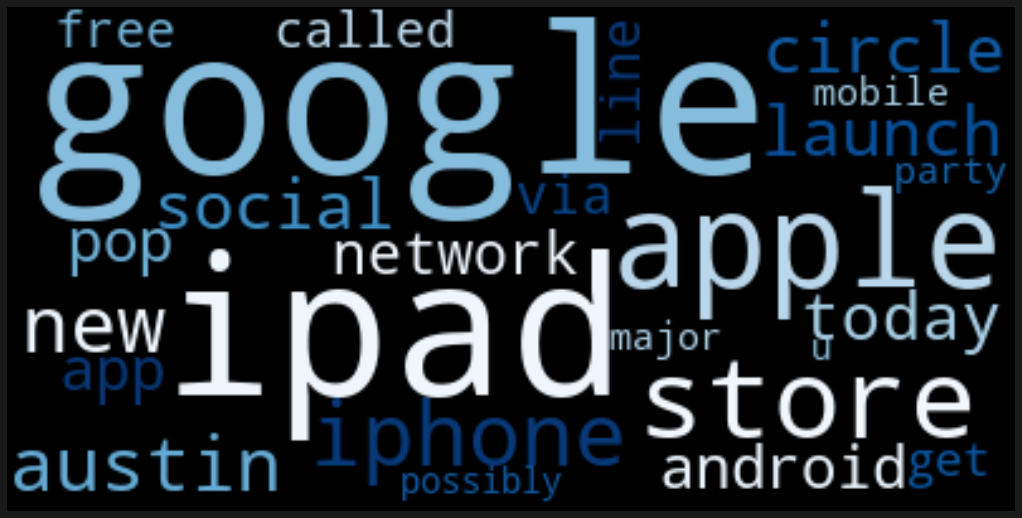

In [133]:
vz.word_cloud(neu_words, 25)

## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [134]:
# filtering
binary_augmented = aug[(aug['emotion'] == 0) |\
                 (aug['emotion'] == 1)].copy()

In [135]:
# resetting the index
binary_augmented.reset_index(drop=True, inplace=True)

In [136]:
# checking the first five rows
binary_augmented.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


In [137]:
# checking the info
binary_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        5871 non-null   int64 
 1   stems          5871 non-null   object
 2   lemmas         5871 non-null   object
 3   tweet          5871 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3868 non-null   object
dtypes: int64(1), object(5)
memory usage: 275.3+ KB


In [138]:
# checking for nulls
binary_augmented.isna().sum()

emotion             0
stems               0
lemmas              0
tweet               0
brand_product    2691
hashtags         2003
dtype: int64

In [139]:
# checking the value counts
binary_augmented['emotion'].value_counts()

0    2968
1    2903
Name: emotion, dtype: int64

## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [140]:
aug_lemms = binary_augmented.lemmas
aug_stems = binary_augmented.stems
aug_target = binary_augmented['emotion']

In [141]:
print(aug_lemms.isna().sum())
aug_stems.isna().sum()

0


0

In [142]:
aug_target.isna().sum()

0

In [143]:
# checking lengths
idx = [aug_lemms, aug_stems, aug_target]
for i in idx:
    print(f'{len(i)}')

5871
5871
5871


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

In [144]:
# Creating data & target
X_lem_aug = aug_lemms
y_lem_aug = aug_target

In [145]:
# checking lengths
print(len(X_lem_aug))
print(len(y_lem_aug))

5871
5871


<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [146]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem_aug,
                                                                           y_lem_aug)

In [147]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [148]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training,
                                                             y_lem_training)

In [149]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

3302
3302
1101
1101


#### Stemmed Data

In [150]:
X_stem_aug = aug_stems
y_stem_aug = aug_target

In [151]:
# checking lengths
print(len(X_stem_aug))
print(len(y_stem_aug))

5871
5871


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [152]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem_aug,
                                                                               y_stem_aug)

In [153]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [154]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training,
                                                                 y_stem_training)

In [155]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

3302
3302
1101
1101


In [156]:
len(X_stem) == len(y_stem)

True

## Baseline Classifier on Augmented Data

In [157]:
baseline.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [158]:
modeling.report(baseline, X_lem_train, y_lem_train, 'baseline_aug', 'augmented data')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


baseline_aug has an average F1 of 0.8904233343568576


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.88498403, 0.89245586, 0.89869281, 0.89105691, 0.88492707])

In [159]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,baseline_aug,0.890423,augmented data


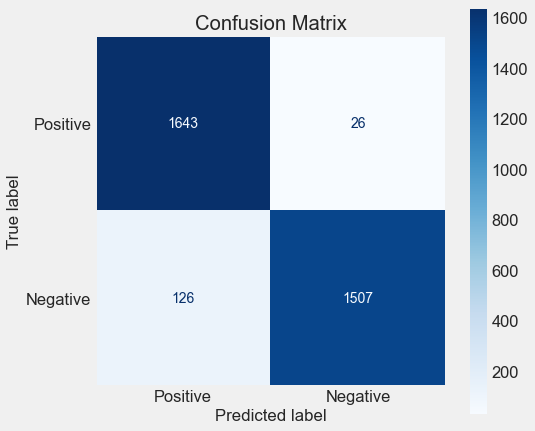

,F1,Recall,Precision
0,0.95199,0.922841,0.98304


In [160]:
fn.confusion_report(baseline, X_lem_train, y_lem_train)

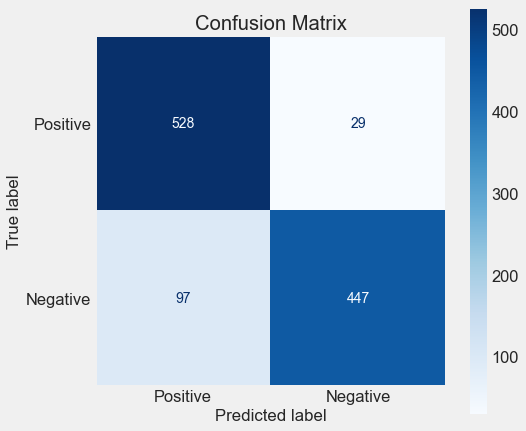

,F1,Recall,Precision
0,0.876471,0.821691,0.939076


In [161]:
fn.confusion_report(baseline, X_lem_val, y_lem_val)

## Baseline Model with Augmented Data Metrics:
<font size="4">F1=0.876471, Recall=0.821691, Precision=0.939076</font>

## Augmented Baseline Coefficients & Odds

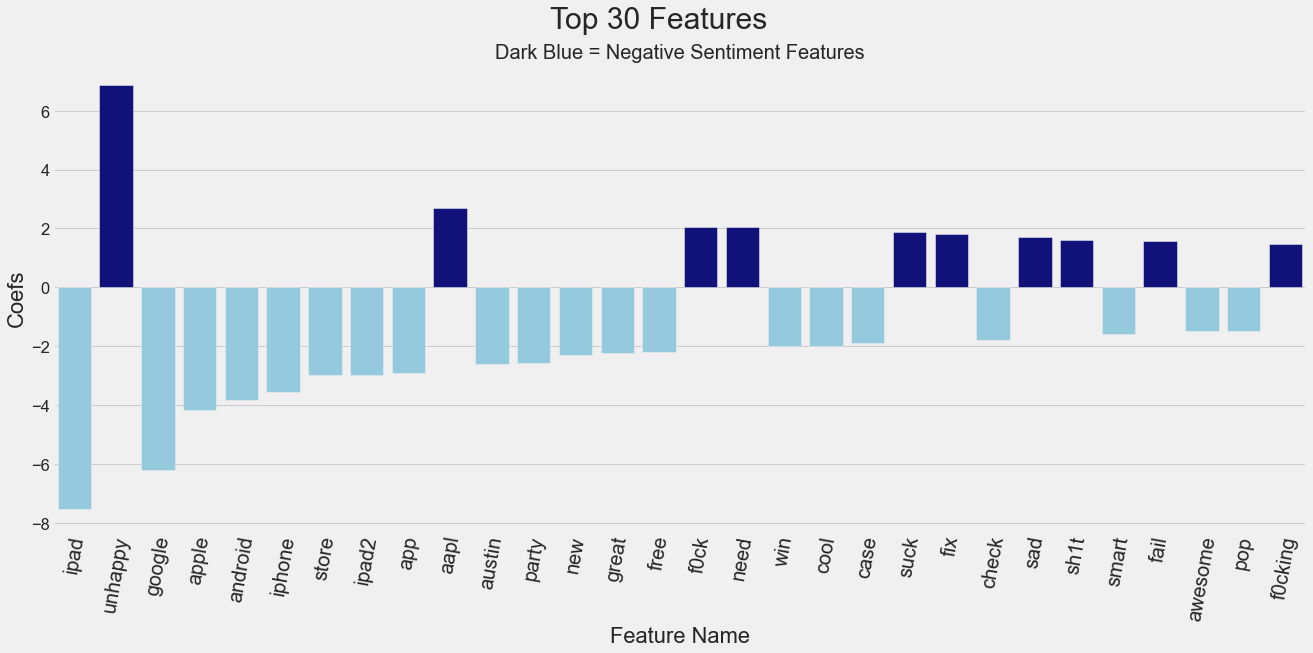

In [162]:
vz.base_coefs(baseline)

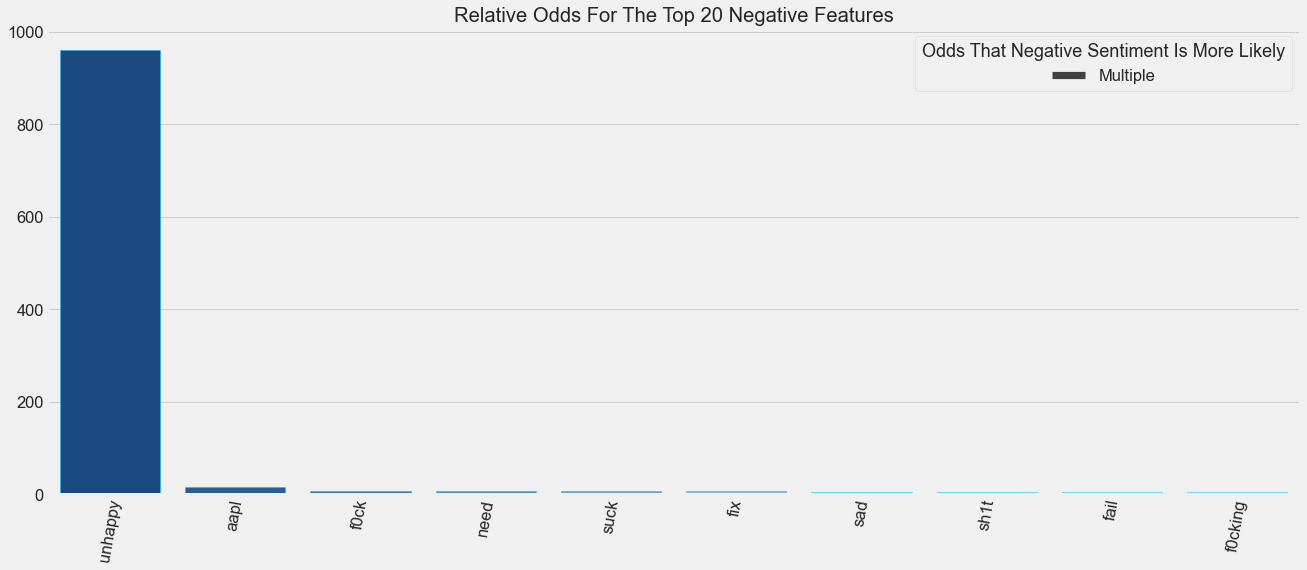

In [163]:
vz.base_neg_odds(baseline)

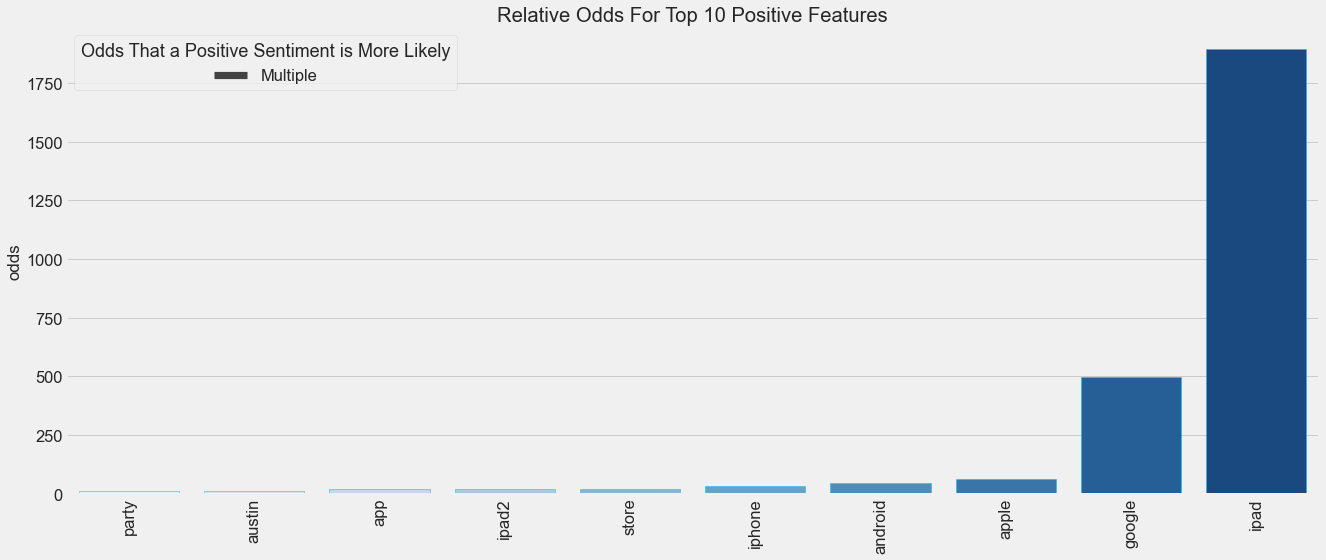

In [164]:
vz.base_pos_odds(baseline)

## Fitting Baseline Model on All Lemmatized, Augmented Data

In [165]:
baseline.fit(X_lem, y_lem)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## Pickling Augmented Baseline Model

In [166]:
# path = os.path.join(gparent, 'models', 'augmented_baseline_model.pkl')
# file = open(path, 'wb')
# pickle.dump(baseline, file)
# file.close()

## Tuned Augmented Baseline

In [167]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [168]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [169]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [170]:
# grid_clf_f1 = GridSearchCV(baseline, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [171]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [172]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
 ('clf',
  LogisticRegression(C=11.288378916846883, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [173]:
tuned_baseline = Pipeline(steps=saved_steps)
tuned_baseline.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [174]:
modeling.report(tuned_baseline, X_lem_train, y_lem_train, 'tuned_baseline_aug',
                f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_aug has an average F1 of 0.896377949045436


array([0.89108911, 0.90113452, 0.89768977, 0.89621087, 0.89576547])

In [175]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,baseline_aug,0.890423,augmented data


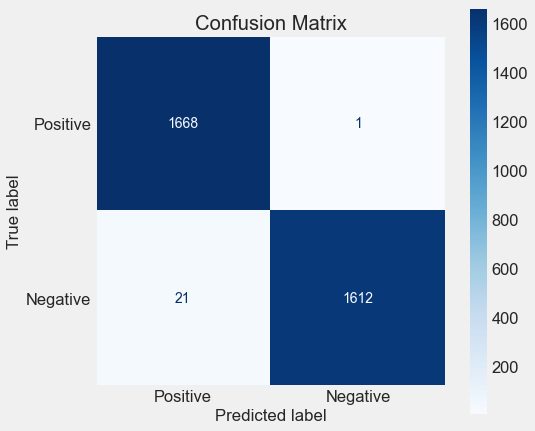

,F1,Recall,Precision
0,0.993222,0.98714,0.99938


In [176]:
fn.confusion_report(tuned_baseline, X_lem_train, y_lem_train)

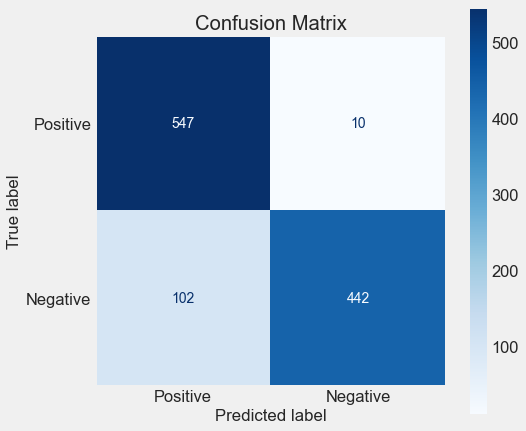

,F1,Recall,Precision
0,0.88755,0.8125,0.977876


In [177]:
fn.confusion_report(tuned_baseline, X_lem_val, y_lem_val)

## Augmented Naive Bayes

In [178]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [179]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes_aug',
                'augmented_data')

multibayes_aug has an average F1 of 0.8589519418868138


array([0.85245902, 0.87086093, 0.86333333, 0.86634461, 0.84176183])

In [180]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
11,multibayes_aug,0.858952,augmented_data


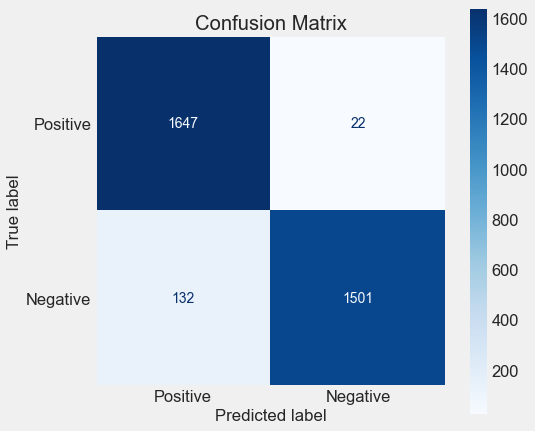

,F1,Recall,Precision
0,0.951204,0.919167,0.985555


In [181]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

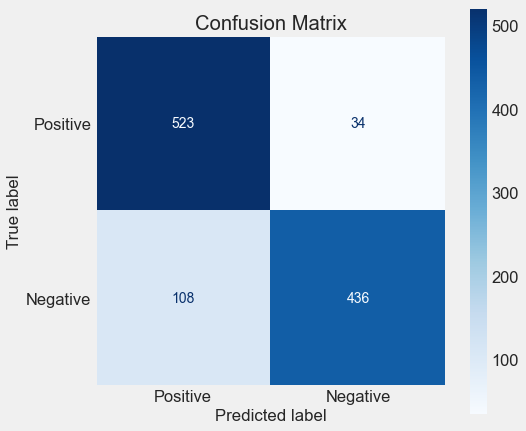

,F1,Recall,Precision
0,0.859961,0.801471,0.92766


In [182]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Augmented Naive Bayes

In [183]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [184]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, .25, .5, .75, 1],
    'clf__fit_prior': [True, False]
    }


In [185]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [186]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [187]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 5), use_idf=False)),
 ('clf', MultinomialNB(alpha=0.25, fit_prior=False))]

In [188]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 5), use_idf=False)),
                ('clf', MultinomialNB(alpha=0.25, fit_prior=False))])

In [189]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_mnb_aug',
                f'{steps}')

tuned_mnb_aug has an average F1 of 0.8735455234135003


array([0.86468647, 0.8830313 , 0.88146912, 0.87725041, 0.86129032])

In [190]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,multibayes_aug,0.858952,augmented_data


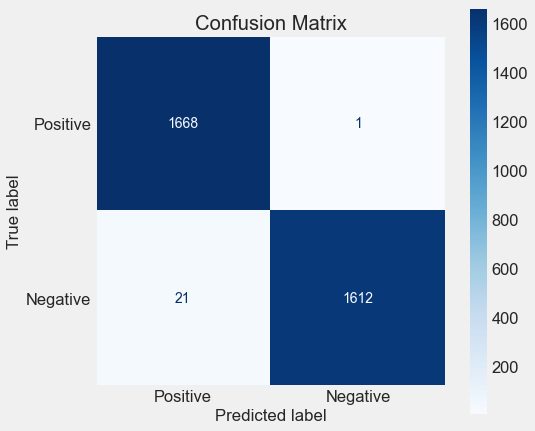

,F1,Recall,Precision
0,0.993222,0.98714,0.99938


In [191]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

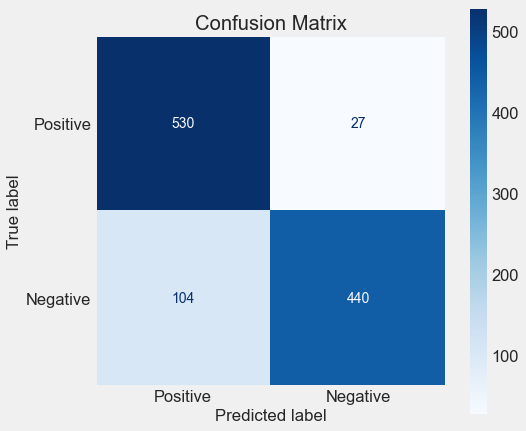

,F1,Recall,Precision
0,0.870425,0.808824,0.942184


In [192]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest on Augmented Data

In [193]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('clf', RF)]
rf_aug = Pipeline(steps=steps)
rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [194]:
modeling.report(rf_aug, X_lem_train, y_lem_train, 'rf_aug', 'augmented data')

rf_aug has an average F1 of 0.8966883615884242


array([0.89326765, 0.90131579, 0.89250814, 0.90196078, 0.89438944])

In [195]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,multibayes_aug,0.858952,augmented_data


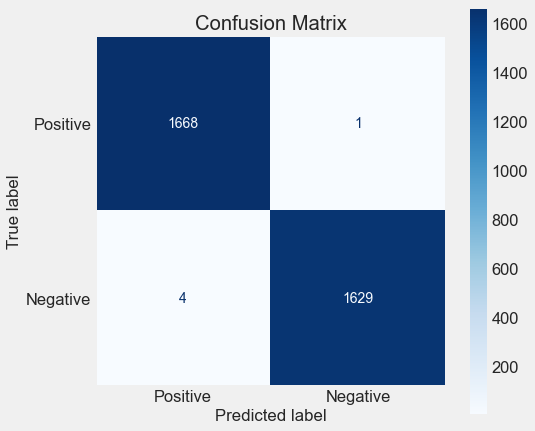

,F1,Recall,Precision
0,0.998468,0.997551,0.999387


In [196]:
fn.confusion_report(rf_aug, X_lem_train, y_lem_train)

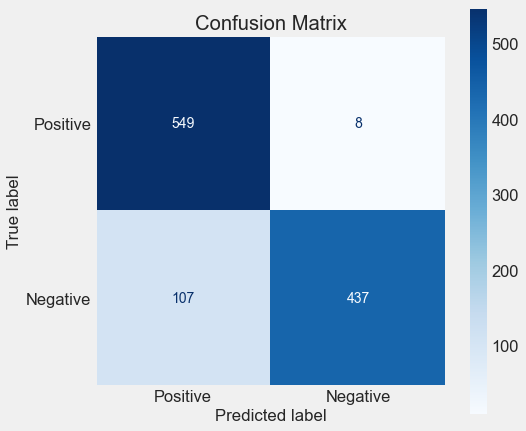

,F1,Recall,Precision
0,0.883721,0.803309,0.982022


In [197]:
fn.confusion_report(rf_aug, X_lem_val, y_lem_val)

## Tuned Augmented Random Forest

In [198]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [199]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [200]:
# grid_clf = GridSearchCV(rf_aug, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [201]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [202]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
 ('clf',
  RandomForestClassifier(min_samples_split=10, n_jobs=-1, random_state=2021))]

In [203]:
tuned_rf_aug = Pipeline(steps=saved_steps)
tuned_rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

In [204]:
modeling.report(tuned_rf, X_lem_train, y_lem_train, 'tuned_rf_aug', f'{steps}')

tuned_rf_aug has an average F1 of 0.8720744586084723


array([0.87562189, 0.87272727, 0.87933884, 0.87458746, 0.85809683])

In [205]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,multibayes_aug,0.858952,augmented_data


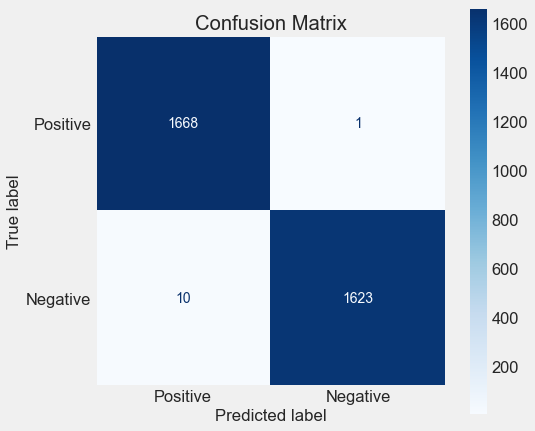

,F1,Recall,Precision
0,0.996623,0.993876,0.999384


In [206]:
fn.confusion_report(tuned_rf_aug, X_lem_train, y_lem_train)

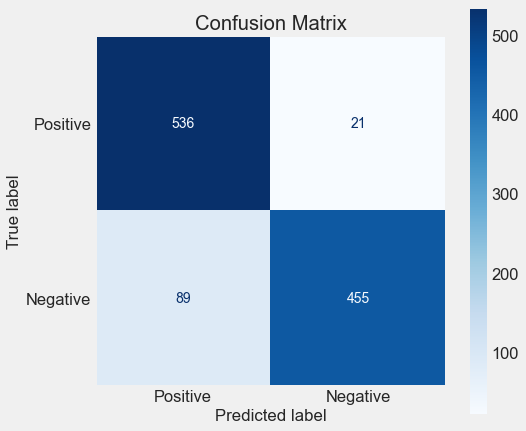

,F1,Recall,Precision
0,0.892157,0.836397,0.955882


In [207]:
fn.confusion_report(tuned_rf_aug, X_lem_val, y_lem_val)

## RF on Stemmed Augmented Data

In [208]:
steps = [('tfidf', tfidf), ('clf', RF)]

In [209]:
stem_rf = Pipeline(steps=saved_steps)
stem_rf.fit(X_stem_train, y_stem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

In [210]:
modeling.report(stem_rf, X_stem_train, y_stem_train, 'rf_stem', f'{steps}')

rf_stem has an average F1 of 0.8934555779954911


array([0.89245586, 0.90996785, 0.88566828, 0.88712242, 0.89206349])

In [211]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,multibayes_aug,0.858952,augmented_data


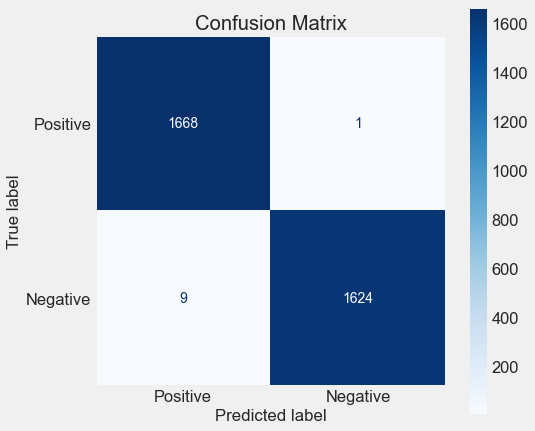

,F1,Recall,Precision
0,0.996931,0.994489,0.999385


In [212]:
fn.confusion_report(stem_rf, X_stem_train, y_stem_train)

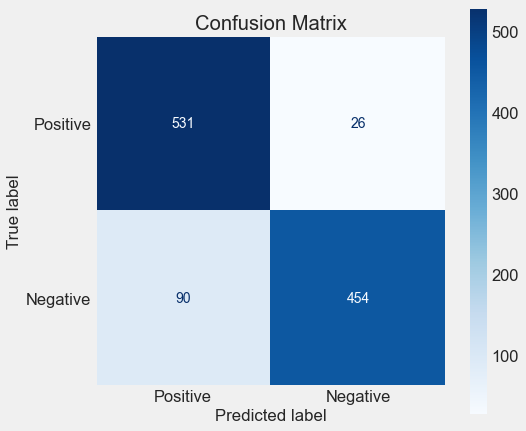

,F1,Recall,Precision
0,0.886719,0.834559,0.945833


In [213]:
fn.confusion_report(stem_rf, X_stem_val, y_stem_val)

## Tuned RF on Augmented Stemmed Data

In [214]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [215]:
# grid_clf = GridSearchCV(stem_rf, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_stem_train, y_stem_train)

In [216]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [217]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
 ('clf',
  RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=2021))]

In [218]:
tuned_stem_rf = Pipeline(steps=saved_steps)
tuned_stem_rf.fit(X_stem_train, y_stem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 RandomForestClassifier(criterion='entropy', n_jobs=-1,
                                        random_state=2021))])

In [219]:
modeling.report(tuned_stem_rf, X_stem_train, y_stem_train, 'tuned_rf_stem',
                f'{steps}')

tuned_rf_stem has an average F1 of 0.8934711705793543


array([0.88745981, 0.90675241, 0.88102894, 0.90322581, 0.88888889])

In [220]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,multibayes_aug,0.858952,augmented_data


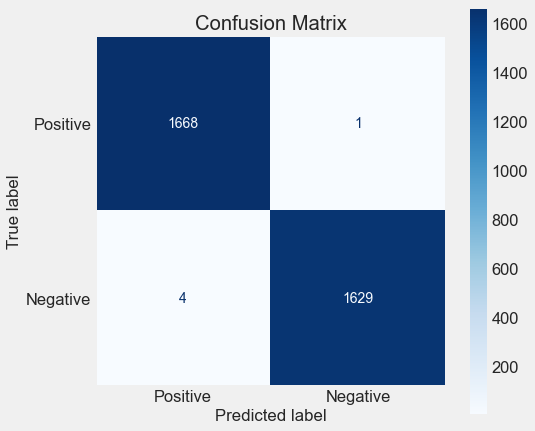

,F1,Recall,Precision
0,0.998468,0.997551,0.999387


In [221]:
fn.confusion_report(tuned_stem_rf, X_stem_train, y_stem_train)

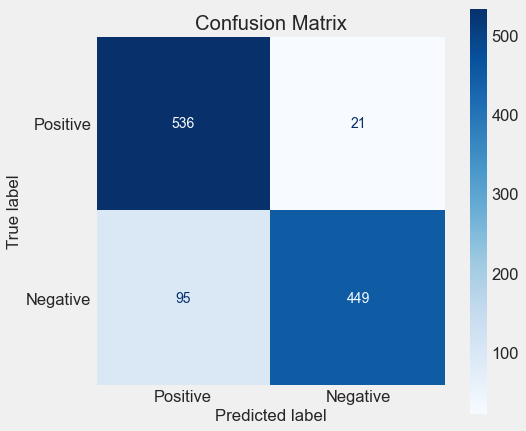

,F1,Recall,Precision
0,0.885602,0.825368,0.955319


In [222]:
fn.confusion_report(tuned_stem_rf, X_stem_val, y_stem_val)

## MVP Model: 
<font size="4">Random Forest CLF Tuned on Augmented Lemmatized Data</font>
    
<font size="4">Metrics: F1=0.892157, Recall=0.836397, Precision=0.955882</font>

In [223]:
tuned_rf_aug.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

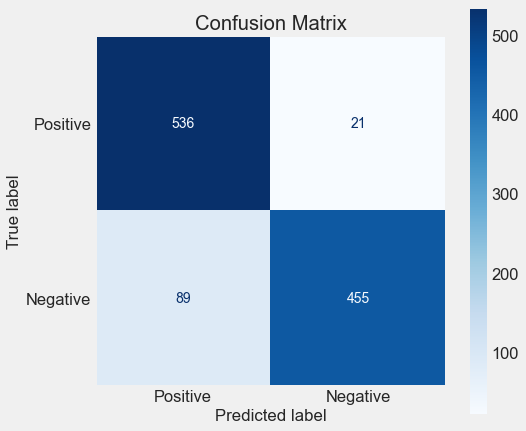

,F1,Recall,Precision
0,0.892157,0.836397,0.955882


In [224]:
fn.confusion_report(tuned_rf_aug, X_lem_val, y_lem_val)

## MVP Model Feature Importances

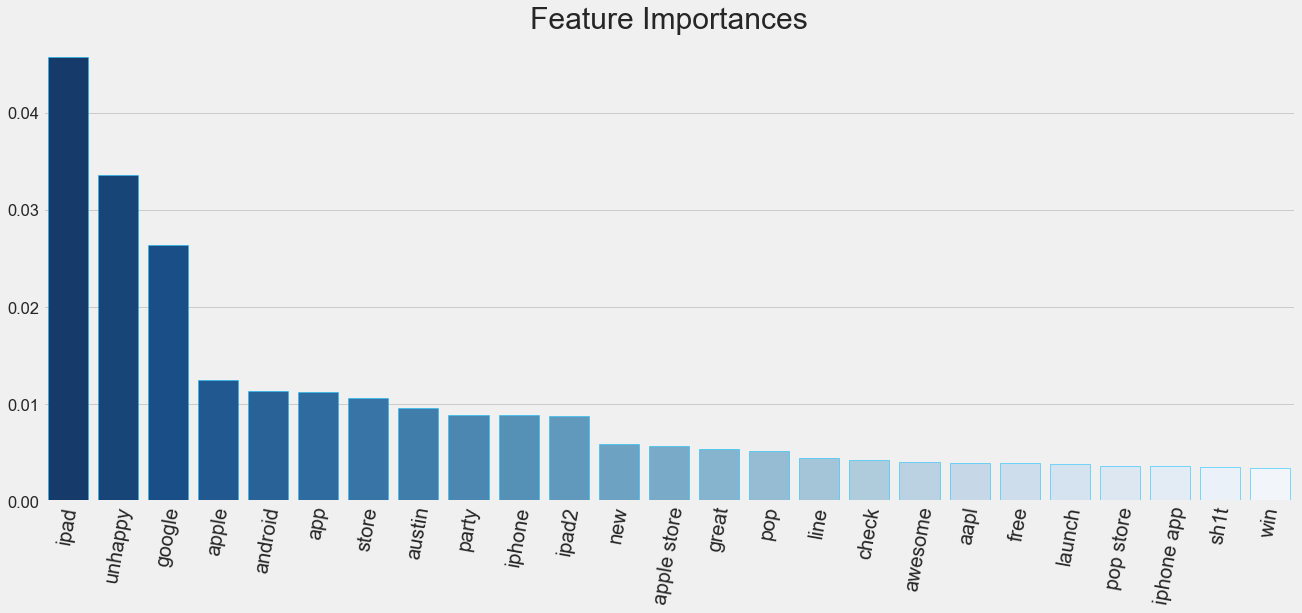

In [225]:
vz.feature_plot(tuned_rf_aug)

## Validating MVP Model on Holdout Data

In [226]:
modeling.report(tuned_rf_aug, X_lem_testing, y_lem_testing, 'MVP_rf_hold_out',
                f'{steps}')

MVP_rf_hold_out has an average F1 of 0.8616913144973617


array([0.86428571, 0.86764706, 0.84805654, 0.86013986, 0.8683274 ])

In [227]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.071395,"tfidf/no ngrams, no sampling"
1,rf_mo,0.394579,default random forest
2,baseline smote,0.450006,smote
3,tuned_baseline_smote,0.461162,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_rf,0.468909,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,tuned_baseline_mo,0.478765,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
6,baseline_mo,0.483339,minority oversampling
7,tuned_multibayes,0.484012,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
8,multibayes,0.485421,minority oversamp
9,multibayes_aug,0.858952,augmented_data


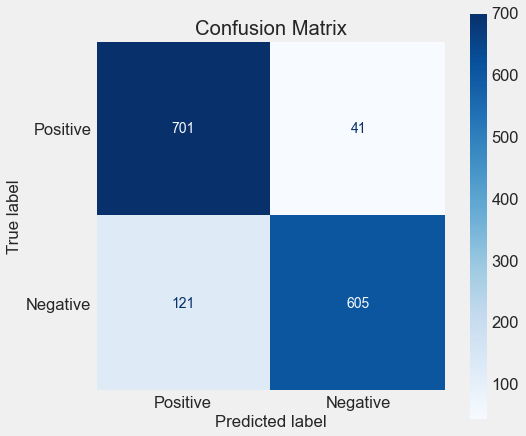

,F1,Recall,Precision
0,0.881924,0.833333,0.936533


In [228]:
fn.confusion_report(tuned_rf_aug, X_lem_testing, y_lem_testing)

## MVP Model Validation Metrics:

<font size="4">F1=0.881924, Recall=0.833333, Precision=0.936533</Font>

## Fitting MVP Model on All Lemmatized Augmented Data

In [229]:
tuned_rf_aug.fit(X_lem_aug, y_lem_aug)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

## Pickling MVP Model

In [230]:
# path = os.path.join(gparent, 'models', 'MVP_model.pkl')
# file = open(path, 'wb')
# pickle.dump(tuned_rf_aug, file)
# file.close()